In [2]:
# MCNN (Multi-Column Convolutional Neural Network) for Crowd Counting with U-Net Comparison

!pip install opencv-python matplotlib --quiet

import os
import cv2
import torch
import random
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [3]:
# ==============================
# Synthetic Dataset for Crowd Counting
# ==============================

class SyntheticCrowdDataset(Dataset):
    def __init__(self, num_samples=100, image_size=(128, 128), max_people=30):
        self.num_samples = num_samples
        self.image_size = image_size
        self.max_people = max_people

    def generate_image_and_density(self):
        image = np.zeros(self.image_size, dtype=np.float32)
        density_map = np.zeros(self.image_size, dtype=np.float32)
        num_people = random.randint(1, self.max_people)

        for _ in range(num_people):
            x = random.randint(0, self.image_size[0] - 1)
            y = random.randint(0, self.image_size[1] - 1)
            image[x, y] = 1.0
            density_map[x, y] = 1.0

        density_map = gaussian_filter(density_map, sigma=3)
        return image, density_map

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        image, density = self.generate_image_and_density()
        image = np.expand_dims(image, axis=0)
        density = np.expand_dims(density, axis=0)
        return torch.tensor(image, dtype=torch.float32), torch.tensor(density, dtype=torch.float32)

train_dataset = SyntheticCrowdDataset(num_samples=200)
val_dataset = SyntheticCrowdDataset(num_samples=50)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)


In [4]:
# ==============================
# MCNN Model Definition
# ==============================

class MCNN(nn.Module):
    def __init__(self):
        super(MCNN, self).__init__()

        def column(in_channels, filters):
            return nn.Sequential(
                nn.Conv2d(in_channels, filters[0], 9, padding=4),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
                nn.Conv2d(filters[0], filters[1], 7, padding=3),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(2),
                nn.Conv2d(filters[1], filters[2], 7, padding=3),
                nn.ReLU(inplace=True),
                nn.Conv2d(filters[2], filters[3], 7, padding=3),
                nn.ReLU(inplace=True)
            )

        self.branch1 = column(1, [16, 32, 16, 8])
        self.branch2 = column(1, [20, 40, 20, 10])
        self.branch3 = column(1, [24, 48, 24, 12])

        self.output_layer = nn.Sequential(
            nn.Conv2d(30, 1, 1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x1 = self.branch1(x)
        x2 = self.branch2(x)
        x3 = self.branch3(x)
        x_cat = torch.cat((x1, x2, x3), dim=1)
        out = self.output_layer(x_cat)
        return F.interpolate(out, size=(128, 128), mode='bilinear', align_corners=False)


In [5]:
# ==============================
# U-Net Model Definition
# ==============================

class DoubleConv(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_c, out_c, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(128, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv2 = DoubleConv(256, 128)
        self.up1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv1 = DoubleConv(128, 64)

        self.output = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        d1 = self.down1(x)
        p1 = self.pool1(d1)
        d2 = self.down2(p1)
        p2 = self.pool2(d2)

        b = self.bottleneck(p2)

        u2 = self.up2(b)
        u2 = torch.cat([u2, d2], dim=1)
        c2 = self.conv2(u2)

        u1 = self.up1(c2)
        u1 = torch.cat([u1, d1], dim=1)
        c1 = self.conv1(u1)

        return self.output(c1)


In [6]:
# ==============================
# Training MCNN and U-Net
# ==============================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_mcnn = MCNN().to(device)
optimizer_mcnn = torch.optim.Adam(model_mcnn.parameters(), lr=1e-4)
criterion = nn.MSELoss()

model_unet = UNet().to(device)
optimizer_unet = torch.optim.Adam(model_unet.parameters(), lr=1e-4)

# Train MCNN
for epoch in range(10):
    model_mcnn.train()
    total_loss = 0
    for images, densities in train_loader:
        images, densities = images.to(device), densities.to(device)
        outputs = model_mcnn(images)
        loss = criterion(outputs, densities)

        optimizer_mcnn.zero_grad()
        loss.backward()
        optimizer_mcnn.step()
        total_loss += loss.item()
    print(f"[MCNN] Epoch {epoch+1}, Loss: {total_loss:.4f}")

# Train U-Net
for epoch in range(10):
    model_unet.train()
    total_loss = 0
    for images, densities in train_loader:
        images, densities = images.to(device), densities.to(device)
        outputs = model_unet(images)
        loss = criterion(outputs, densities)

        optimizer_unet.zero_grad()
        loss.backward()
        optimizer_unet.step()
        total_loss += loss.item()
    print(f"[U-Net] Epoch {epoch+1}, Loss: {total_loss:.4f}")


[MCNN] Epoch 1, Loss: 0.3368
[MCNN] Epoch 2, Loss: 0.0008
[MCNN] Epoch 3, Loss: 0.0003
[MCNN] Epoch 4, Loss: 0.0003
[MCNN] Epoch 5, Loss: 0.0003
[MCNN] Epoch 6, Loss: 0.0002
[MCNN] Epoch 7, Loss: 0.0003
[MCNN] Epoch 8, Loss: 0.0002
[MCNN] Epoch 9, Loss: 0.0002
[MCNN] Epoch 10, Loss: 0.0003
[U-Net] Epoch 1, Loss: 0.0113
[U-Net] Epoch 2, Loss: 0.0007
[U-Net] Epoch 3, Loss: 0.0003
[U-Net] Epoch 4, Loss: 0.0002
[U-Net] Epoch 5, Loss: 0.0001
[U-Net] Epoch 6, Loss: 0.0001
[U-Net] Epoch 7, Loss: 0.0001
[U-Net] Epoch 8, Loss: 0.0000
[U-Net] Epoch 9, Loss: 0.0000
[U-Net] Epoch 10, Loss: 0.0000


In [8]:
# ==============================
# Evaluation Loop
# ==============================

def evaluate_model(model, dataloader, device):
    model.eval()
    mae, mse = 0, 0
    with torch.no_grad():
        for images, gt_densities in dataloader:
            images = images.to(device)
            gt_counts = gt_densities.sum(dim=(1, 2, 3)).cpu().numpy()
            preds = model(images).cpu()
            pred_counts = preds.sum(dim=(1, 2, 3)).numpy()

            mae += np.abs(gt_counts - pred_counts).sum()
            mse += ((gt_counts - pred_counts) ** 2).sum()

    n = len(dataloader.dataset)
    return mae / n, np.sqrt(mse / n)

# Create DataLoader
val_loader = DataLoader(val_dataset, batch_size=8)

# Evaluate both models
mae_unet, rmse_unet = evaluate_model(model_unet, val_loader, device)
mae_mcnn, rmse_mcnn = evaluate_model(model_mcnn, val_loader, device)

print(f"U-Net:  MAE = {mae_unet:.2f}, RMSE = {rmse_unet:.2f}")
print(f"MCNN:   MAE = {mae_mcnn:.2f}, RMSE = {rmse_mcnn:.2f}")



U-Net:  MAE = 7.11, RMSE = 7.68
MCNN:   MAE = 14.38, RMSE = 16.36


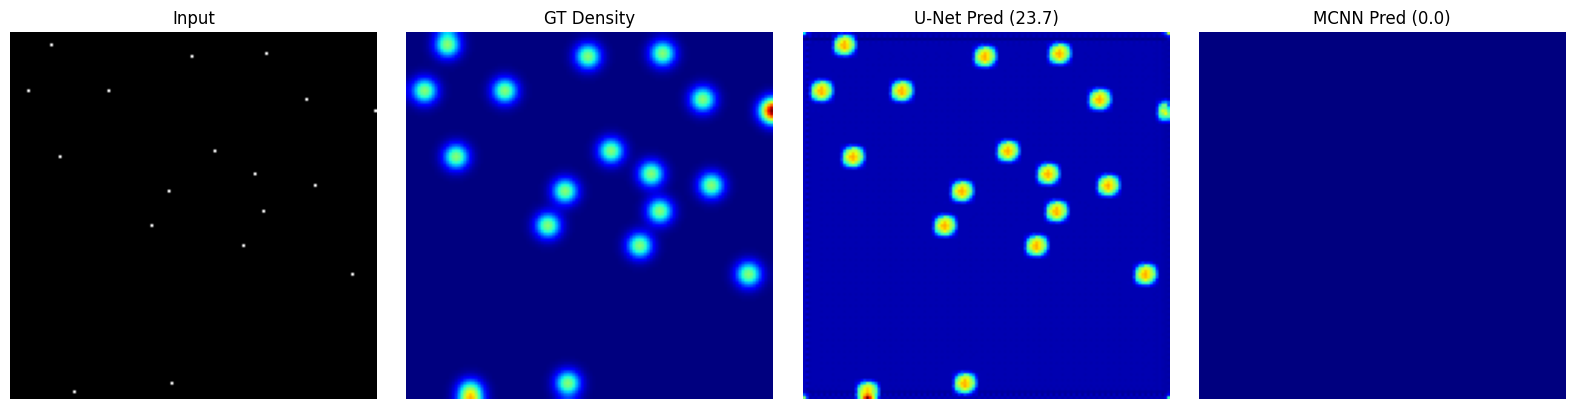

In [9]:
# ==============================
# Visualization
# ==============================

model_unet.eval()
model_mcnn.eval()
with torch.no_grad():
    img, gt = val_dataset[0]
    input_img = img.unsqueeze(0).to(device)
    pred_unet = model_unet(input_img).squeeze().cpu().numpy()
    pred_mcnn = model_mcnn(input_img).squeeze().cpu().numpy()

    def visualize_predictions(img, gt, pred_unet, pred_mcnn):
        fig, axs = plt.subplots(1, 4, figsize=(16, 4))
        axs[0].imshow(img.squeeze(), cmap='gray'); axs[0].set_title("Input")
        axs[1].imshow(gt.squeeze(), cmap='jet'); axs[1].set_title("GT Density")
        axs[2].imshow(pred_unet, cmap='jet'); axs[2].set_title(f"U-Net Pred ({pred_unet.sum():.1f})")
        axs[3].imshow(pred_mcnn, cmap='jet'); axs[3].set_title(f"MCNN Pred ({pred_mcnn.sum():.1f})")
        for ax in axs: ax.axis('off')
        plt.tight_layout(); plt.show()

    visualize_predictions(img, gt, pred_unet, pred_mcnn)
